# Homework 2: Classification and Clustering

Q1: 20 pts

Q2: 20 pts

Q3: 30 pts

Q4: 30 pts

Q5: 65 pts

Q6: 2 pts (administrative)

Total: 167 pts

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('error')

Below, we provide starter code for this assignment. Explanations and documentation are provided as these elements are invoked throughout this notebook. **Please do not edit this starter code**. 

* ``gauss_pm`` and ``poiss_pm``: objects for storing model parameters.

* ``pklload``: function that loads pickle files.

In [4]:
import os
import pickle
from collections import namedtuple

# gauss_pm: stores parameters for Gaussian classification models.
# Once created, you can call each parameter by calling instance.parameter.
# E.g. ``gauss_pm_instance.mu``.
gauss_pm = namedtuple(
    "gauss_pm",
    [
        "pi",    # prior probabilities for each class
        "mu",    # class-conditional mean parameters
        "sigma", # class-conditional covariance parameters
        "acc",   # classification accuracy
        "mesg",  # students may ignore this
    ],
)

# poiss_pm: stores parameters for Poisson classification models.
poiss_pm = namedtuple(
    "poiss_pm",
    [
        "pi",   # prior probabilities for each class
        "lam",  # rate parameter, \lambda
        "acc",  # classification accuracy
        "mesg", # students may ignore this
    ],
)

def pklload(*args) -> dict:
    """ Load pkl files.
    
    Args:
        *args: the folder path leading to the pkl file, in order

    Returns:
        data (dict): dictionary containing the data
    """
    f = open(os.path.join(*args), "rb")
    data = pickle.load(f)
    f.close()
    return data

## Question 3: Simulated Data (30 pts)

For Question 3, execute the block below, then scroll down and start from the code block **"Question 3(a-e)"**, and follow instructions from there.

In [5]:
# Load data

data = np.load("./HW2_data/sim_data.npy")
n_classes, n_trials, n_neurons = data.shape

# For saving model parameters, key: (problem set number, model number)
mdl_params = {}

### Question 3(b): Find Maximum-Likelihood Model Parameters

Fill in the functions for training the parameters for models (i)-(iii), then execute the blocks.

In [13]:
def train_gaussian_shared_cov(data: np.ndarray, n_classes: int, n_trials: int, n_neurons: int) -> tuple:
    """Estimate parameters for model (i): Gaussian with shared covariance across classes.

    Args:
        data (np.ndarray): Training data, shape (n_classes, n_trials, n_neurons).
        n_classes (int): Number of stimulus classes.
        n_trials (int): Number of trials per class.
        n_neurons (int): Number of recorded neurons (features).

    Returns:
        tuple:
            pi (np.ndarray): Class priors, shape (n_classes,).
            mu (np.ndarray): Class means, shape (n_classes, n_neurons).
            sigma (np.ndarray): Shared covariance matrix replicated for each class,
                                shape (n_classes, n_neurons, n_neurons).
    """
    # ----- YOUR CODE HERE ----- #

    # IMPORTANT: Ensure that sigma has the shape specified above, ensuring that the same shared
    # covariance matrix is used to model each of the classes. 
    
    pi = np.zeros(n_classes)
    mu = np.zeros((n_classes, n_neurons))
    sigma = np.zeros((n_classes, n_neurons, n_neurons))

    S_k = np.zeros((n_classes, n_neurons, n_neurons))

    N = n_classes * n_trials

    for k in range(n_classes):
        class_data = data[k]
        N_k = n_trials 

        pi[k] = N_k / N

        mu[k] = np.mean(class_data, axis=0)

        S_k[k] = ((class_data - mu[k]).T @ (class_data - mu[k])) / N_k
    
    sigma_shared = sum(pi[k] * S_k[k] for k in range(n_classes))
    sigma = np.tile(sigma_shared, (n_classes, 1, 1))

    # -------------------------- #

    # --- SHAPE CHECKS ---
    assert pi.shape == (n_classes,), f"Expected pi shape {(n_classes,)}, got {pi.shape}"
    assert mu.shape == (n_classes, n_neurons), f"Expected mu shape {(n_classes, n_neurons)}, got {mu.shape}"
    assert sigma.shape == (n_classes, n_neurons, n_neurons), \
        f"Expected sigma shape {(n_classes, n_neurons, n_neurons)}, got {sigma.shape}"

    return pi, mu, sigma

pi, mu, sigma = train_gaussian_shared_cov(data, n_classes, n_trials, n_neurons)
mdl_params[(3, 0)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=None)

In [15]:
def train_gaussian_class_cov(data: np.ndarray, n_classes: int, n_trials: int, n_neurons: int) -> tuple:
    """Estimate parameters for model (ii): Gaussian with class-specific covariance matrices.

    Args:
        data (np.ndarray): Training data, shape (n_classes, n_trials, n_neurons).
        n_classes (int): Number of stimulus classes.
        n_trials (int): Number of trials per class.
        n_neurons (int): Number of recorded neurons (features).

    Returns:
        tuple:
            pi (np.ndarray): Class priors, shape (n_classes,).
            mu (np.ndarray): Class means, shape (n_classes, n_neurons).
            sigma (np.ndarray): Class-specific covariance matrices,
                                shape (n_classes, n_neurons, n_neurons).
    """
    # ----- YOUR CODE HERE ----- #

    pi = np.zeros(n_classes)
    mu = np.zeros((n_classes, n_neurons))
    sigma = np.zeros((n_classes, n_neurons, n_neurons))

    N = n_classes * n_trials

    for k in range(n_classes):
        class_data = data[k]
        N_k = n_trials 

        pi[k] = N_k / N

        mu[k] = np.mean(class_data, axis=0)

        sigma[k] = ((class_data - mu[k]).T @ (class_data - mu[k])) / N_k
    

    # -------------------------- #

    # --- SHAPE CHECKS ---
    assert pi.shape == (n_classes,), f"Expected pi shape {(n_classes,)}, got {pi.shape}"
    assert mu.shape == (n_classes, n_neurons), f"Expected mu shape {(n_classes, n_neurons)}, got {mu.shape}"
    assert sigma.shape == (n_classes, n_neurons, n_neurons), \
        f"Expected sigma shape {(n_classes, n_neurons, n_neurons)}, got {sigma.shape}"

    return pi, mu, sigma

pi, mu, sigma = train_gaussian_class_cov(data, n_classes, n_trials, n_neurons)
mdl_params[(3, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=None)

In [16]:
def train_poisson(data: np.ndarray, n_classes: int, n_trials: int, n_neurons: int) -> tuple:
    """Estimate parameters for model (iii): Poisson.

    Args:
        data (np.ndarray): Input data, shape (n_classes, n_trials, n_neurons).
        n_classes (int): Number of stimulus classes.
        n_trials (int): Number of trials per class.
        n_neurons (int): Number of recorded neurons (dimensions).

    Returns:
        tuple:
            pi (np.ndarray): Class priors, shape (n_classes,).
            lam (np.ndarray): Class-specific Poisson rate parameters,
                              shape (n_classes, n_neurons).
    """
    # ----- YOUR CODE HERE ----- #

    pi = np.zeros(n_classes)
    lam = np.zeros((n_classes, n_neurons))

    N = n_classes * n_trials

    for k in range(n_classes):
        class_data = data[k]
        N_k = n_trials 

        pi[k] = N_k / N

        lam[k] = np.mean(class_data, axis=0)

    # -------------------------- #

    # --- SHAPE CHECKS ---
    assert pi.shape == (n_classes,), f"Expected pi shape {(n_classes,)}, got {pi.shape}"
    assert lam.shape == (n_classes, n_neurons), f"Expected lam shape {(n_classes, n_neurons)}, got {lam.shape}"

    return pi, lam

pi, lam = train_poisson(data, n_classes, n_trials, n_neurons)
mdl_params[(3, 2)] = poiss_pm(pi=pi, lam=lam, acc=None, mesg=None)

### Question 3(d): Gaussian PDF

Fill in the function for calculating the probability density function for a Gaussian variable, then excute the block.

In [30]:
def gaussian_pdf(data: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """Compute the probability density function (PDF) of a multivariate Gaussian distribution.

    Args:
        data (np.ndarray): Input data points, shape (n_points, n_dims).
        mu (np.ndarray): Mean vector of the distribution, shape (n_dims,).
        sigma (np.ndarray): Covariance matrix of the distribution, shape (n_dims, n_dims).

    Returns:
        pdf (np.ndarray): PDF values evaluated at each input point, shape (n_points,).
    """
    
    n_points, n_dims = data.shape
    
    # ----- YOUR CODE HERE ----- #
    
    diff = data - mu 

    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)

    frac = 1 / np.sqrt((2 * np.pi) ** n_dims * sigma_det)
    exp = -0.5 * np.sum(diff @ sigma_inv * diff, axis=1)

    pdf = frac * np.exp(exp)
    
    # -------------------------- #
    
    assert pdf.shape == (n_points,), f"Expected pdf shape {(n_points,)}, but got {pdf.shape}"

    return pdf


### Question 3(e): Decision Boundary

Complete the functions for calculating the loglikelihood and decision boundary of the Gaussian and Poisson models, then execute the block.

In [60]:
def loglikelihood_gaussian(data: np.ndarray, pi: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """Compute the log-likelihood of each data point under a multivariate Gaussian model.

    Args:
        data (np.ndarray): Data points, shape (n_samples, n_neurons).
        pi (np.ndarray): Class priors, shape (n_classes,).
        mu (np.ndarray): Class means, shape (n_classes, n_neurons).
        sigma (np.ndarray): Class covariance matrices, shape (n_classes, n_neurons, n_neurons).

    Returns:
        np.ndarray: Log-likelihood for each data point and class, shape (n_samples, n_classes).
    """
    # ----- YOUR CODE HERE ----- #

    n_samples, n_neurons = data.shape
    n_classes = pi.shape[0]

    ll = np.zeros((n_samples, n_classes))

    for k in range(n_classes):
        sigma_inv = np.linalg.inv(sigma[k])
        sigma_det = np.linalg.det(sigma[k])

        diff = data - mu[k] 

        log_pdf = -0.5 * np.sum(diff @ sigma_inv * diff, axis=1)
        log_pdf += -0.5 * (n_neurons * np.log(2 * np.pi) + np.log(sigma_det))

        ll[:, k] = log_pdf + np.log(pi[k])

    return ll

    # -------------------------- #


def decision_boundary_gaussian(data: np.ndarray, pi: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """Classify each data point using the Gaussian model with MAP decision rule.

    Args:
        data (np.ndarray): Data points, shape (n_samples, n_neurons).
        pi (np.ndarray): Class priors, shape (n_classes,).
        mu (np.ndarray): Class means, shape (n_classes, n_neurons).
        sigma (np.ndarray): Class covariance matrices, shape (n_classes, n_neurons, n_neurons).

    Returns:
        np.ndarray: Predicted class labels, shape (n_samples,).
    """
    # ----- YOUR CODE HERE ----- #

    ll = loglikelihood_gaussian(data, pi, mu, sigma)
    pred = np.argmax(ll, axis=1)
    return pred

    # -------------------------- #


def loglikelihood_poisson(data: np.ndarray, pi: np.ndarray, lam: np.ndarray) -> np.ndarray:
    """Compute the log-likelihood of each data point under a multivariate Poisson model.

    Args:
        data (np.ndarray): Data points, shape (n_samples, n_neurons).
        pi (np.ndarray): Class priors, shape (n_classes,).
        lam (np.ndarray): Class-specific Poisson rate parameters, shape (n_classes, n_neurons).

    Returns:
        np.ndarray: Log-likelihood for each data point and class, shape (n_samples, n_classes).
    """
    # ----- YOUR CODE HERE ----- #

    n_samples, n_neurons = data.shape
    n_classes = pi.shape[0]

    ll = np.zeros((n_samples, n_classes))

    for k in range(n_classes):
        log_lam = np.log(lam[k])

        log_pdf = np.sum(data * log_lam - lam[k], axis=1)

        ll[:, k] = log_pdf + np.log(pi[k])

    return ll

    # -------------------------- #


def decision_boundary_poisson(data: np.ndarray, pi: np.ndarray, lam: np.ndarray) -> np.ndarray:
    """Classify each data point using the Poisson model with MAP decision rule.

    Args:
        data (np.ndarray): Data points, shape (n_samples, n_neurons).
        pi (np.ndarray): Class priors, shape (n_classes,).
        lam (np.ndarray): Class-specific Poisson rate parameters, shape (n_classes, n_neurons).

    Returns:
        np.ndarray: Predicted class labels, shape (n_samples,).
    """
    # ----- YOUR CODE HERE ----- #

    ll = loglikelihood_poisson(data, pi, lam)
    preds = np.argmax(ll, axis=1)
    return preds

    # -------------------------- #


### Question 3(a-e)

**Putting it all together and into action!**

HINT: when working with each part, if you want to check your progress before moving on, comment out the other parts to avoid errors. Alternatively, put ``continue`` at the end of the part to skip the rest of the code.

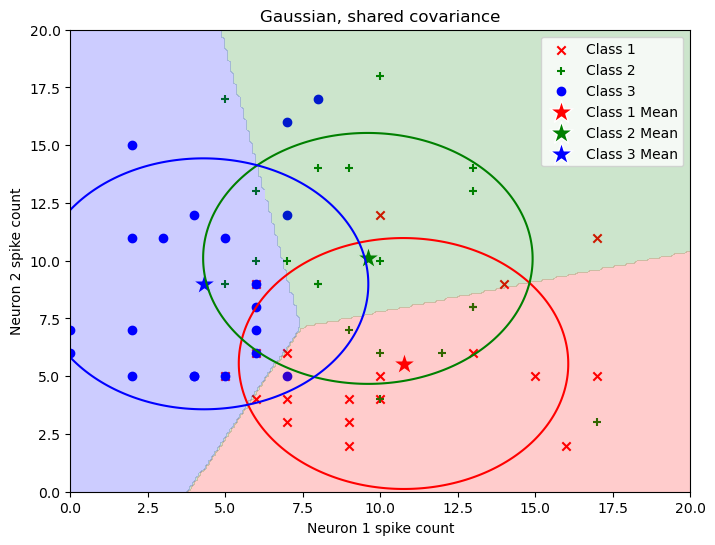

<Figure size 640x480 with 0 Axes>

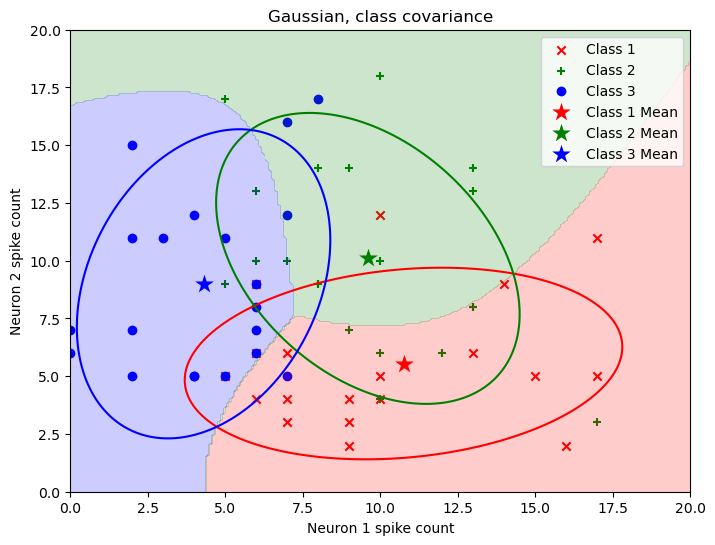

<Figure size 640x480 with 0 Axes>

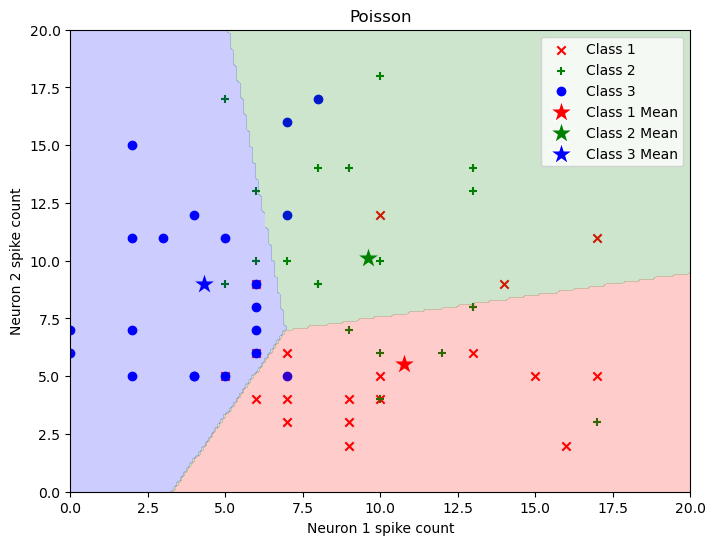

<Figure size 640x480 with 0 Axes>

In [37]:
titles = ["Gaussian, shared covariance", 
          "Gaussian, class covariance", 
          "Poisson"]

for model_idx in range(3):

    # Set up the figure
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    axs.set_xlim((0, 20))
    axs.set_ylim((0, 20))

    # Part (a): Plot training data
    # ----- YOUR CODE HERE ----- #
    #
    colors = ['r', 'g', 'b']
    markers = ['x', '+', 'o']
    labels = ['Class 1', 'Class 2', 'Class 3']

    for k in range(n_classes):
        class_data = data[k]
        plt.scatter(class_data[:, 0], class_data[:, 1],
                c=colors[k], marker=markers[k], label=labels[k])

    plt.xlabel("Neuron 1 spike count")
    plt.ylabel("Neuron 2 spike count")
    
    # -------------------------- #

    # Part (b): Obtain parameter estimates
    # ----- NOTHING REQUIRED HERE --- #
    # Complete and execute your Q3(b) code block to populate
    # the model parameters in mdl_params.
    # ------------------------------- #
    
    mpm = mdl_params[(3, model_idx)]
    if isinstance(mpm, gauss_pm):
        mdl_type = "gaussian"
        mu, sigma, pi = mpm.mu, mpm.sigma, mpm.pi
    elif isinstance(mpm, poiss_pm):
        mdl_type = "poisson"
        mu = lam = mpm.lam
        pi = mpm.pi

    # Part (c): Plot class means
    # ----- YOUR CODE HERE ----- #
    #
    for k in range(n_classes):
        plt.scatter(mu[k, 0], mu[k, 1],
                c=colors[k], marker='*', s=300, edgecolor='white', label=f"Class {k+1} Mean")
    # -------------------------- #

    # Part (d): Plot Gaussian density contours
    # ----- YOUR CODE HERE ----- #
    # First go to code block Q3(d) to finish the function ``gaussian_pdf``,
    # Then come back and finish this section.
    #
    if mdl_type == "gaussian":
        x = np.linspace(0, 20, 200)
        y = np.linspace(0, 20, 200)
        X, Y = np.meshgrid(x, y)
        grid = np.column_stack([X.ravel(), Y.ravel()])

        for k in range(n_classes):
            Z = gaussian_pdf(grid, mu[k], sigma[k]).reshape(X.shape)
            axs.contour(X, Y, Z, levels=[0.004], colors=[colors[k]])
    # -------------------------- #

    # Part (e): Plot decision boundaries
    # ----- YOUR CODE HERE ----- #
    # First go to code block Q3(e) to finish the ``decision_boundary`` functions,
    # Then come back and finish this section.
    #
    x = np.linspace(0, 20, 200)
    y = np.linspace(0, 20, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.column_stack([X.ravel(), Y.ravel()])

    if mdl_type == "gaussian":
        preds = decision_boundary_gaussian(grid, pi, mu, sigma)
    elif mdl_type == "poisson":
        preds = decision_boundary_poisson(grid, pi, lam)

    preds = preds.reshape(X.shape)

    axs.contourf(X, Y, preds, alpha=0.2, levels=np.arange(-0.5, n_classes, 1), colors=colors)
    # -------------------------- #

    axs.set_title(titles[model_idx])
    plt.legend()
    plt.show(model_idx + 1)
    plt.clf()

## Question 4: Real Neural Data (30 pts)

### Question 4(a): Estimate Model Parameters

In [38]:
# Load data

train = np.load("HW2_data/reach_train.npy")
test = np.load("HW2_data/reach_test.npy")
n_classes, n_trials, n_neurons = train.shape

In [41]:
# Estimate model parameters

# ----- YOUR CODE HERE ----- #
# HINT: Use your code from Q3.
# 
pi, mu, sigma = train_gaussian_shared_cov(train, n_classes, n_trials, n_neurons)
# -------------------------- #

In [42]:
# Decision boundary

# ----- YOUR CODE HERE ----- #
# HINT: Use your code from Q3.
test_data = test.reshape(-1, n_neurons)

true_labels = np.repeat(np.arange(n_classes), n_trials)

pred_labels = decision_boundary_gaussian(test_data, pi, mu, sigma)

acc = np.mean(pred_labels == true_labels)
# -------------------------- #

print(f"Model(i) accuracy: {acc:.4f}")

# Save model parameters
mdl_params[(4, 0)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=acc, mesg=None)

Model(i) accuracy: 0.9588


### Question 4(b): Python Warning

In [44]:
# Estimate model parameters
    
# ----- YOUR CODE HERE ----- #
# HINT: Use your code from Q3.
#
pi, mu, sigma = train_gaussian_class_cov(train, n_classes, n_trials, n_neurons)
# -------------------------- #

In [55]:
# Decision boundary

for k in range(n_classes):
    # test_data = test.reshape(-1, n_neurons)

    # true_labels = np.repeat(np.arange(n_classes), n_trials)

    # pred_labels = decision_boundary_gaussian(test_data, pi, mu, sigma)

    # acc = np.mean(pred_labels == true_labels)
    # print(f"Model(ii) accuracy: {acc:.4f}")

    #     # Save model parameters
    # mdl_params[(4, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=acc, mesg=None)
    try:
        # ----- YOUR CODE HERE ----- #
        # HINT: you can re-use the code from Q3.
        test_data = test.reshape(-1, n_neurons)

        true_labels = np.repeat(np.arange(n_classes), n_trials)

        pred_labels = decision_boundary_gaussian(test_data, pi, mu, sigma)

        acc = np.mean(pred_labels == true_labels)
        print(f"Model(ii) accuracy: {acc:.4f}")

        # Save model parameters
        mdl_params[(4, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=acc, mesg=None)
        # -------------------------- #
    except Exception as e:
        print("The following error was raised: " + str(e))

The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix
The following error was raised: Singular matrix


In [48]:
# What was the cause of the error message?

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = "The covariance matrix is singular, which means its determinant is 0 and thus it cannot be inverted. " \
"This can be for multiple reasons, one of them being that the matrix is low rank (lesser trials than number of neurons). Because the covariance is " \
"calculated by taking the outer product, the rank of this is the number of trails, which is lesser than the number of neurons."
# -------------------------- #

print(f"The cause of the error message is: {ans}")

# Save model parameters
mdl_params[(4, 1)] = gauss_pm(pi=pi, mu=mu, sigma=sigma, acc=None, mesg=ans)

The cause of the error message is: The covariance matrix is singular, which means its determinant is 0 and thus it cannot be inverted. This can be for multiple reasons, one of them being that the matrix is low rank (lesser trials than number of neurons). Because the covariance is calculated by taking the outer product, the rank of this is the number of trails, which is lesser than the number of neurons.


### Question 4(c): Python Warning

In [52]:
# Calculate model parameters

# ----- YOUR CODE HERE ----- #
# HINT: Use your code from Q3.
#
pi, lam = train_poisson(train, n_classes, n_trials, n_neurons)
mdl_params[(4, 2)] = poiss_pm(pi=pi, lam=lam, acc=None, mesg=None)
# -------------------------- #

In [54]:
# Decision boundary

for k in range(n_classes):
    try:
        # ----- YOUR CODE HERE ----- #
        # HINT: you can re-use the code from Q3.
        test_data = test.reshape(-1, n_neurons)

        true_labels = np.repeat(np.arange(n_classes), n_trials)

        pred_labels = decision_boundary_poisson(test_data, pi, lam)

        acc = np.mean(pred_labels == true_labels)
        print(f"Model(iii) accuracy: {acc:.4f}")

        # -------------------------- #
    except Exception as e:
        print("The following error was raised: " + str(e))


# try:
#     # ----- YOUR CODE HERE ----- #
#     # HINT: you can re-use the code from Q3.
#     test_data = test.reshape(-1, n_neurons)

#     true_labels = np.repeat(np.arange(n_classes), n_trials)

#     pred_labels = decision_boundary_poisson(test_data, pi, lam)

#     acc = np.mean(pred_labels == true_labels)
#     print(f"Model(iii) accuracy: {acc:.4f}")

#     # -------------------------- #
# except Exception as e:
#     print("The following error was raised: " + str(e))

The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log
The following error was raised: divide by zero encountered in log


In [56]:
# What was the cause of the error message?

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = "Some neurons never spike, making it so that when we calculate the log-likelihood, we take the log of 0.  "
# -------------------------- #

print(f"The cause of the error message is: {ans}")

# Save model parameters
mdl_params[(4, 2)] = poiss_pm(pi=pi, lam=lam, acc=None, mesg=ans)

The cause of the error message is: Some neurons never spike, making it so that when we calculate the log-likelihood, we take the log of 0.  


### Question 4(d): Minimum Variance Poisson Model

In [ ]:
def train_min_var_poisson(data: np.ndarray, n_classes: int, n_trials: int, n_neurons: int, min_var=0.01) -> tuple:
    """Estimate parameters for the modified Poisson model.

    Args:
        data (np.ndarray): Input data, shape (n_classes, n_trials, n_neurons).
        n_classes (int): Number of stimulus classes.
        n_trials (int): Number of trials per class.
        n_neurons (int): Number of recorded neurons (dimensions).

    Returns:
        tuple:
            pi (np.ndarray): Class priors, shape (n_classes,).
            lam (np.ndarray): Class-specific Poisson rate parameters,
                              shape (n_classes, n_neurons).
    """
    # ----- YOUR CODE HERE ----- #

    pi = np.zeros(n_classes)
    lam = np.zeros((n_classes, n_neurons))

    N = n_classes * n_trials

    for k in range(n_classes):
        class_data = data[k]
        N_k = n_trials 

        pi[k] = N_k / N

        lam[k] = np.mean(class_data, axis=0)
        lam[k] = np.maximum(lam[k], 0.01)

    
    # -------------------------- #
    
    # --- SHAPE CHECKS ---
    assert pi.shape == (n_classes,), f"Expected pi shape {(n_classes,)}, got {pi.shape}"
    assert lam.shape == (n_classes, n_neurons), f"Expected lam shape {(n_classes, n_neurons)}, got {lam.shape}"

    return pi, lam


pi, lam_mv = train_min_var_poisson(train, n_classes, n_trials, n_neurons)
# pi, lam_mv = poiss_mod(data, n_classes, n_trials, n_neurons)

In [63]:
# Decision boundary

# ----- YOUR CODE HERE ----- #
# HINT: Use your code from Q3.
test_data = test.reshape(-1, n_neurons)

true_labels = np.repeat(np.arange(n_classes), n_trials)

pred_labels = decision_boundary_poisson(test_data, pi, lam_mv)

acc = np.mean(pred_labels == true_labels)

# -------------------------- #

print(f"Model(iv) accuracy: {acc:.4f}")

# Save model parameters
mdl_params[(4, 2)] = poiss_pm(pi=pi, lam=lam_mv, acc=acc, mesg=None)

Model(iv) accuracy: 0.9396


## Question 5: EM Algroithm for GMM (65 pts)

In [ ]:
# Load data

data = pklload("HW2_data/spike_sorting.pkl")
pm1 = data["InitParams1"]
pm2 = data["InitParams2"]
spikes = data["spikes"]

K = pm1["mu"].shape[1] # number of clusters in InitParams1
D = spikes.shape[0] # number of timesteps per spike snippet
N = spikes.shape[1] # number of spike snippets

### Question 5(a)

We provide the code to you for this one!

In [ ]:
# Plot all of the spike snippets. We want to use a GMM to spike sort these snippets.

f_0 = 30000 # original sampling frequency (Hz)
t = 1000 * np.arange(D) / f_0 # Time (ms)

plt.figure(figsize=(6, 4))
plt.plot(t, spikes, 'k', alpha=0.2)
plt.ylim([np.min(spikes), np.max(spikes)])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title('All spike snippets')
plt.tight_layout()

### Question 5(b)

Write the EM algorithm for the Gaussian Mixture Model, and plot the log likelihood as a function of iteration steps.

In [ ]:
def EM_GMM(spikes: np.array, init_params: dict):
    """ EM algorithm for Gaussian mixture model.
    
    Args:
        spikes (np.array): shape of (31, 552)
        init_params: dict containing parameter initializations.
            has (key, value) pairs:
            "mu": array of shape (31, 3)
            "sigma": array of shape (31, 31, 3)
            "pi": array of shape (1, 3)
    
    Returns:
        mu (np.array): shape of (31, 3)
        sigma (np.array): shape of (31, 31, 3)
        pi (np.array): shape of (3,)
        gam (np.array): shape of (3, 552)
        LL (array-like): contains log-likelihood at each iteration step
    """
    # ----- YOUR CODE HERE ----- #
    raise NotImplementedError
    # -------------------------- #

In [ ]:
mu, sigma, ppi, gam, LL = EM_GMM(spikes, pm1)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4))
axs[0].plot(LL, "b")
axs[1].plot(LL[:10], "b")
axs[1].set_xlabel("steps")
axs[0].set_ylabel("log likelihood")
axs[1].set_ylabel("log likelihood")
plt.tight_layout()
plt.show()

What are the $\pi$ values? Remember, they should sum to 1.

In [ ]:
print(f"The pi values are: {ppi}")

For each cluster (k = 1, 2, 3), create a separate “voltage versus time” plot.

In [ ]:
cluster_assignments = np.argmax(gam, axis=0)

plt.figure(figsize=(8, 6))
for k in range(K):
    plt.subplot(K, 1, k + 1)

    # ----- YOUR CODE HERE ----- #
    pass
    # -------------------------- #
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (μV)')
    plt.tight_layout()
    plt.title('Spike snippets assigned to cluster {}'.format(k + 1))
plt.show()

### Question 5(c)

Run the EM algorithm on the same data as in Problem 2, but now initializing the model parameters using InitParams2. This should lead to an error. Why did the error occur?

In [ ]:
try:
    # ----- YOUR CODE HERE ----- #
    pass
    # -------------------------- #
except Exception as e:
    print("The following error was raised: " + str(e))

# ----- YOUR CODE HERE ----- #
# Put your answer in the string ``ans``.
# HINT: To see a more complete error message, you can remove the exception handling (try-except) in the previous code block.
ans = NotImplemented
# -------------------------- #

print(f"The cause of the error message is: {ans}")

### Question 6 (administrative)

About how many hours did you spend on this homework? There is no right or wrong answer :-)